In [1]:
# import libraries
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm
from safe.utils import compute_side_chains
import csv
from rdkit import Chem
from rdkit import Chem, rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
from rdkit.Chem import Descriptors
import matplotlib as mpl
from rdkit import Chem

print('RDKit version: ',rdBase.rdkitVersion)
print('MatplotLib version:', mpl.__version__)

/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RDKit version:  2023.09.3
MatplotLib version: 3.8.2


## Scaffold Morphing
It requires side chains as input.

Steps:
* Get SMILES
* Extract core from SMILES (convert SMILES to molecule to do this)
* Pass in SMILES and core to generate side chain
* Finally, pass in side chain to the model to generate the molecules for scaffold morphing.

In the rest of this notebook, I'll be playing around with codes to achieve different parts of this.

# Visualize Input SMILES

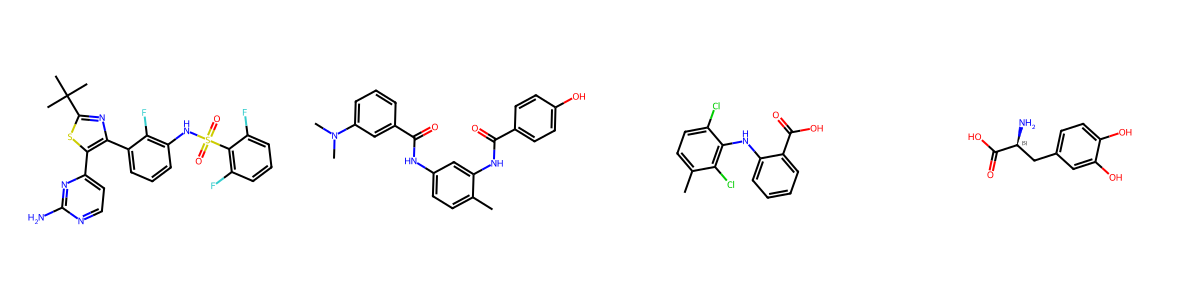

In [2]:
# read SMILES from .csv file, assuming one column with header
with open("data/my_molecules.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    smiles_list = [r[0] for r in reader]

dm.to_image(smiles_list)

# Testing the main.py script

In [3]:
# convert SMILES to SAFE
def smiles_to_safe(smiles):
    try:
        safe = sf.encode(smiles)
        return safe
    # except sf.EncoderError:
    except:
        print("Error in SMILES conversion")


def extract_core_structure(SMILES):
    # Define scaffold parameter network
    params = rdScaffoldNetwork.ScaffoldNetworkParams()
    # customize parameter attributes
    params.includeScaffoldsWithoutAttachments=False
    mol = Chem.MolFromSmiles(SMILES)
    net = rdScaffoldNetwork.CreateScaffoldNetwork([mol],params)
    nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]

    filtered_list = []
    for mol in nodemols:
        # Check for the presence of attachment points and molecular weight range
        if "*" in Chem.MolToSmiles(mol) and 60 < Descriptors.MolWt(mol) < 100:
            filtered_list.append(mol)
    
    # If there are no scaffolds within the range, select the closest one
    if not filtered_list:
        closest_mol = min(nodemols, key=lambda x: abs(Descriptors.MolWt(x) - 80))
        filtered_list.append(closest_mol)
    
    # Sort the filtered list based on the number of heteroatoms (fewer carbons)
    filtered_list.sort(key=lambda x: x.GetNumHeavyAtoms())

    return filtered_list


def get_side_chain_pairs(side_chains):
    '''Function to break the side chains into pairs'''
    side_chains_pairs = []
    side_chains_smiles = Chem.MolToSmiles(side_chains).split(".")
    n = len(side_chains_smiles)

    for i in range(n):
        for j in range(i+1, n):
            # Clip off the first four characters for consistent numbering
            adjusted_side_chain_i = side_chains_smiles[i][4:]
            adjusted_side_chain_j = side_chains_smiles[j][4:]

            # Use [1*] and .[2*] consistently
            new_pair = f"[1*]{adjusted_side_chain_i}.[2*]{adjusted_side_chain_j}"
            side_chains_pairs.append(Chem.MolFromSmiles(new_pair))

    return side_chains_pairs


# generate new smiles
def generate_smiles(side_chain):
    generated_smiles = designer.scaffold_morphing(
        side_chains=side_chain,
        n_samples_per_trial=12,
        n_trials=1,
        sanitize=True,
        do_not_fragment_further=False,
        random_seed=100,)
    return generated_smiles

# my model
def my_model(SMILES):
    generated_smiles = []
    for i in SMILES:
        row = []
        # extract the core structures for each SMILES
        core_structures = extract_core_structure(i)
        # generate new molecules for each side chain of the smile
        for core in core_structures:
            # compute side chain
            side_chain = compute_side_chains(core=core, mol=i)
            # get side chain pairs
            side_chain_pairs = get_side_chain_pairs(side_chain)
            for side_chain in side_chain_pairs:
                # generate new molecules for each side chain of the smile
                output = generate_smiles(side_chain)
                row += output
        # remove duplicates in the row
        row = list(set(row))
        generated_smiles += [row]

    return generated_smiles 



# read SMILES from .csv file, assuming one column with header
with open("data/my_molecules.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    smiles_list = [r[0] for r in reader]

# Load pre-trained model
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

# # convert to SAFE
safe_list = [smiles_to_safe(smi) for smi in smiles_list]

# run model
outputs = my_model(safe_list)
# remove duplicate smiles
outputs = list(set(outputs))
print("Length of output:", len(outputs))
outputs

[12:53:30] Running LargestFragmentChooser
[12:53:30] Fragment: CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1
[12:53:30] New largest fragment: CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1 (55)
  0%|          | 0/1 [00:00<?, ?it/s]/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-02-01 12:53:48.425 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 0 / 12 (0.00 %)  generated molecules are valid !
  0%|          | 0/1 [00:00<?, ?it/s][12:54:17] 

****
Range Error
idx
Violation occurred on line 222 in file /project/build/temp.linux-x86_64-cpython-39/rdkit/Code/GraphMol/ROMol.cpp
Failed Expression: 28 < 28
****

2024-02-01 12:54:17.522 | INFO     | safe.samp

TypeError: unhashable type: 'list'

Length of output: 7


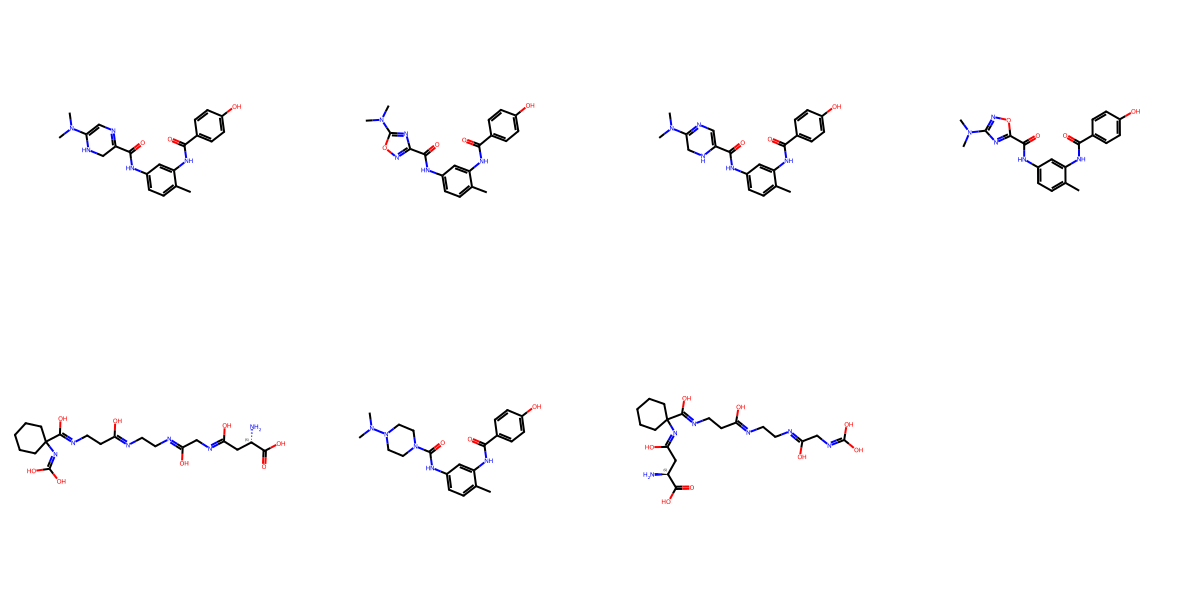

In [ ]:
print("Length of output:", len(outputs))
dm.to_image(outputs)